In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os

In [52]:
# Define the file paths and country names
file_paths = {
    'benin': '../data/benin-malanville.csv',
    'sierraleone': '../data/sierraleone-bumbuna.csv',
    'togo': '../data/togo-dapaong_qc.csv',
}

# Load the dataframes into a dictionary
dataframes = {}
for country, file_path in file_paths.items():
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Data file not found for {country}: {file_path}")
    dataframes[country] = pd.read_csv(file_path)


In [53]:
#visualizing the general summary statistics for all numeric columns for each country

for country, df in dataframes.items():
    print(f"\n---{country}---")
    print(df.describe())


---benin---
                 GHI            DNI            DHI           ModA  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      240.559452     167.187516     115.358961     236.589496   
std       331.131327     261.710501     158.691074     326.894859   
min       -12.900000      -7.800000     -12.600000       0.000000   
25%        -2.000000      -0.500000      -2.100000       0.000000   
50%         1.800000      -0.100000       1.600000       4.500000   
75%       483.400000     314.200000     216.300000     463.700000   
max      1413.000000     952.300000     759.200000    1342.300000   

                ModB           Tamb             RH             WS  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      228.883576      28.179683      54.487969       2.121113   
std       316.536515       5.924297      28.073069       1.603466   
min         0.000000      11.000000       2.100000       0.000000   
25%         0.000000

In [54]:
# counting missing values in each column 

for country, df in dataframes.items():
    print(f"\n---{country}---")
    missing_values = df.isna().sum()
    print(missing_values)

    # List columns with >5% nulls
    total_rows = len(df)
    columns_with_high_nulls = missing_values[missing_values > (0.05 * total_rows)]
    print("\nColumns with >5% nulls:")
    print(columns_with_high_nulls)


---benin---
Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64

Columns with >5% nulls:
Comments    525600
dtype: int64

---sierraleone---
Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments  

In [56]:
# detecting outliers using z-score and performing basic data-cleaning by dropping and imputing missing values 

''' Outlier Detection:
 Z-scores measure how far each data point is from the mean, in terms of standard deviations.
 Here, we calculate the Z-score for each value in the specified columns ('GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust').
 A Z-score greater than 3 (or less than -3) is often considered an outlier, indicating that the data point is significantly far from the mean.
'''
columns_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
for country, df in dataframes.items(): 
    for col in columns_to_check:
        df[f'{col}_Z'] = np.abs(stats.zscore(df[col]))

    df['Outlier'] = 0 
    for col in columns_to_check:
        df.loc[df[f'{col}_Z'] > 3, 'Outlier'] = 1
    print(f"\n---{country}---")
    print(df['Outlier'].value_counts())

'''
Drop rows where GHI, DNI, or DHI are missing.
Impute missing values in 'ModA', 'ModB', 'WS', and 'WSgust' with their respective medians.
'''
for country, df in dataframes.items(): 
    df.dropna(subset=['GHI', 'DNI', 'DHI'], inplace=True)
    for col in ['ModA', 'ModB', 'WS', 'WSgust']:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val) 


#exporting cleaned dataset to data folder

for country, df in dataframes.items(): 
    df.to_csv(f"../data/{country}_clean.csv", index=False)




---benin---
Outlier
0    517860
1      7740
Name: count, dtype: int64

---sierraleone---
Outlier
0    509308
1     16292
Name: count, dtype: int64

---togo---
Outlier
0    516349
1      9251
Name: count, dtype: int64


C:\Users\HP RTZEN\miniconda3\envs\venv-solar-challenge\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


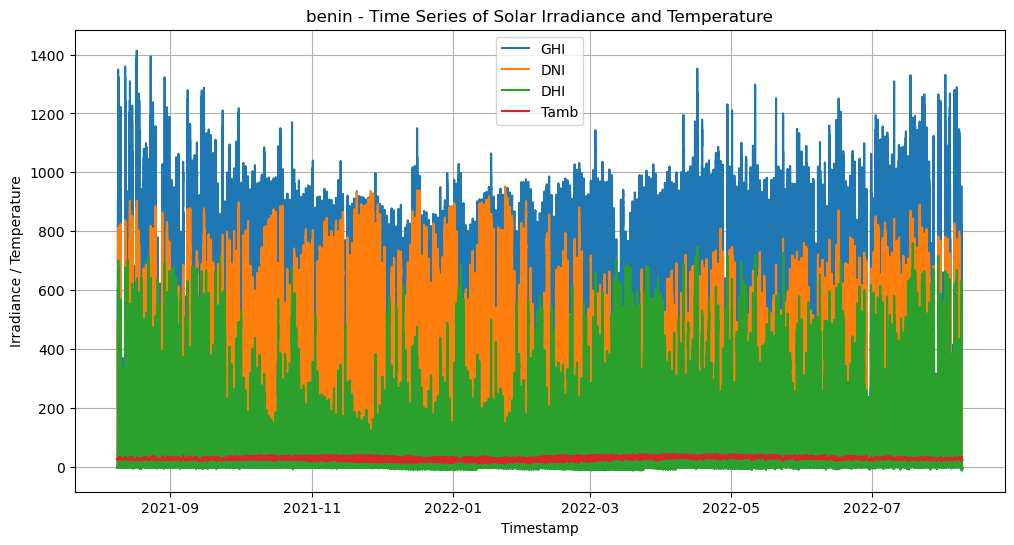

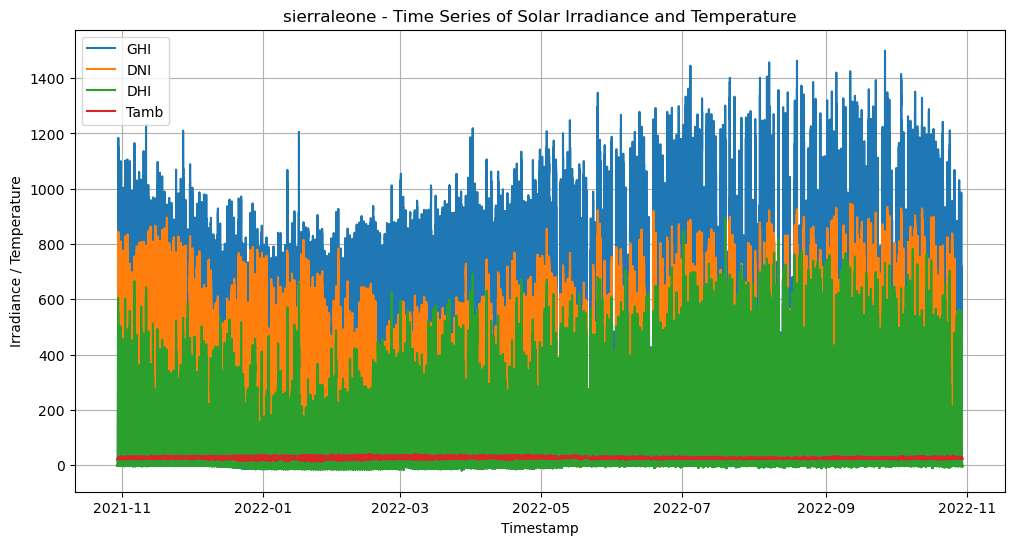

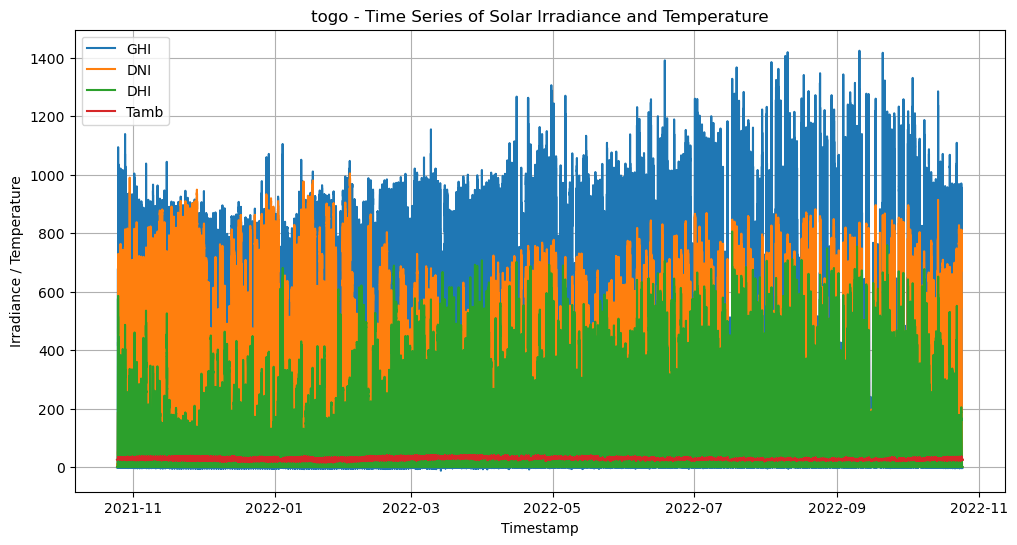

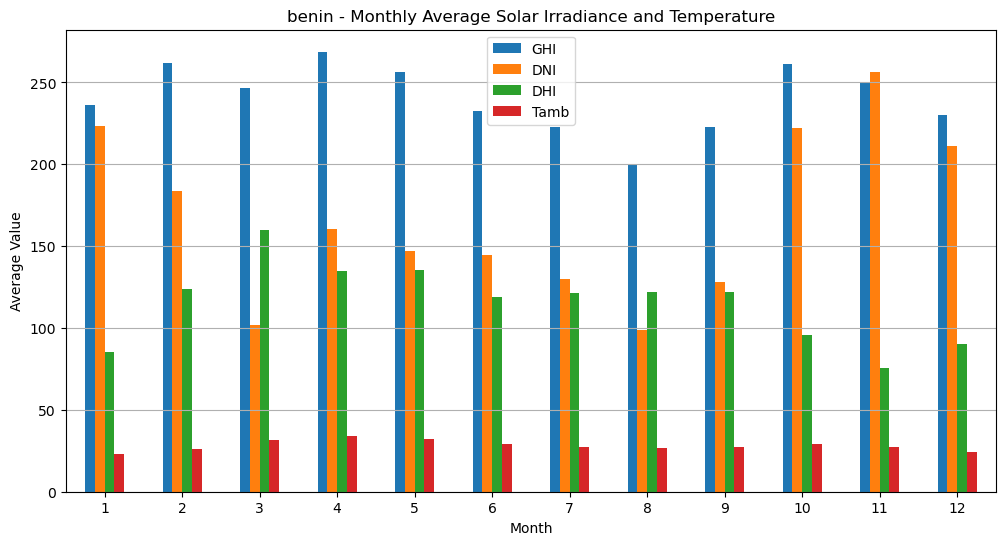

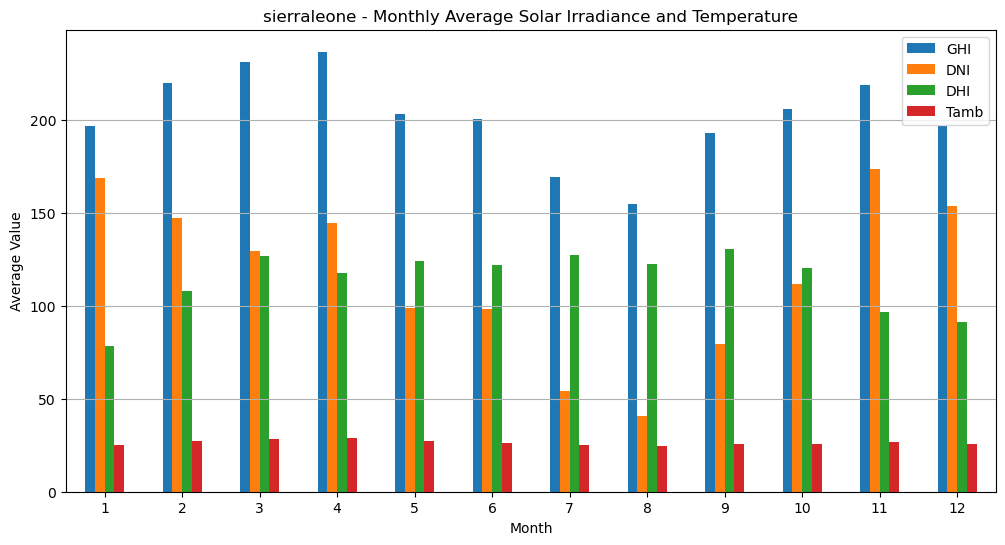

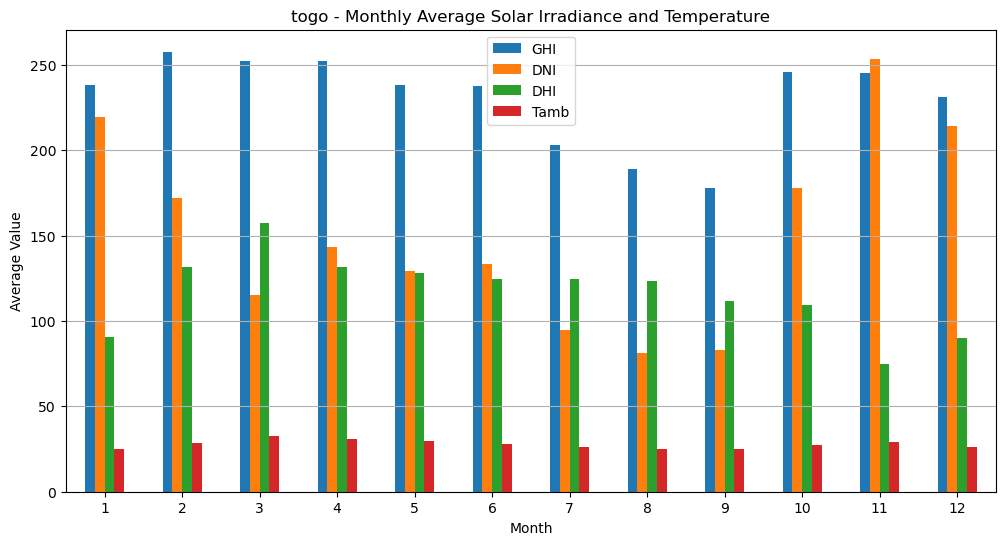

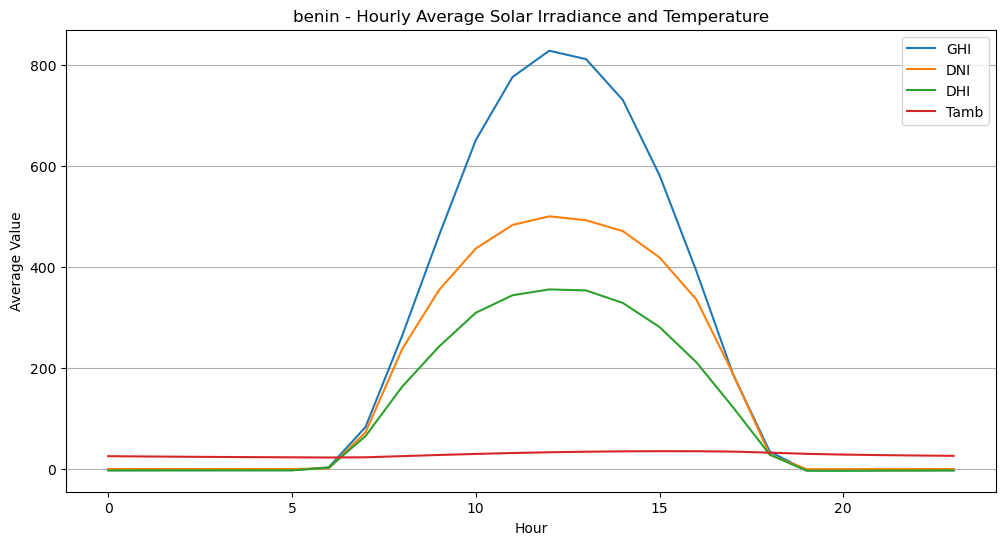

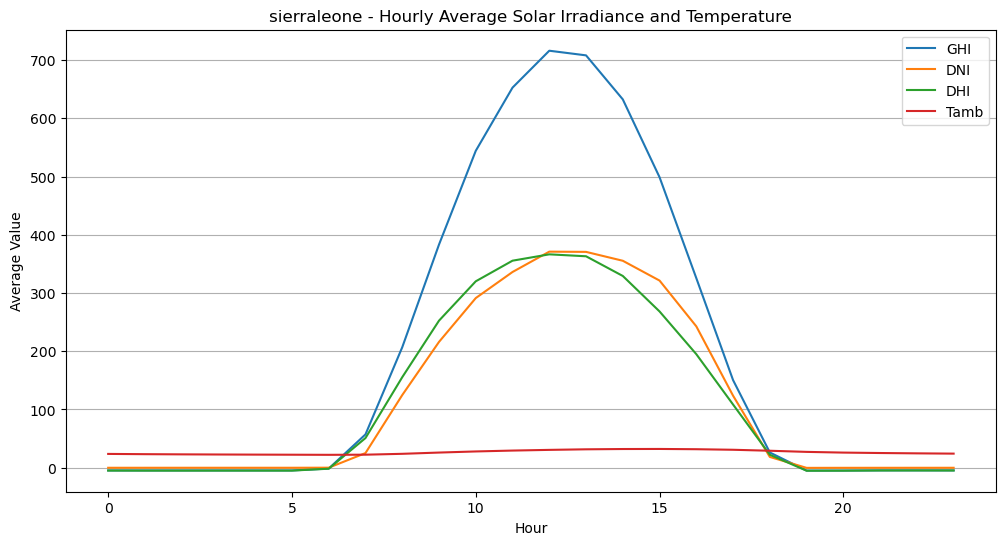

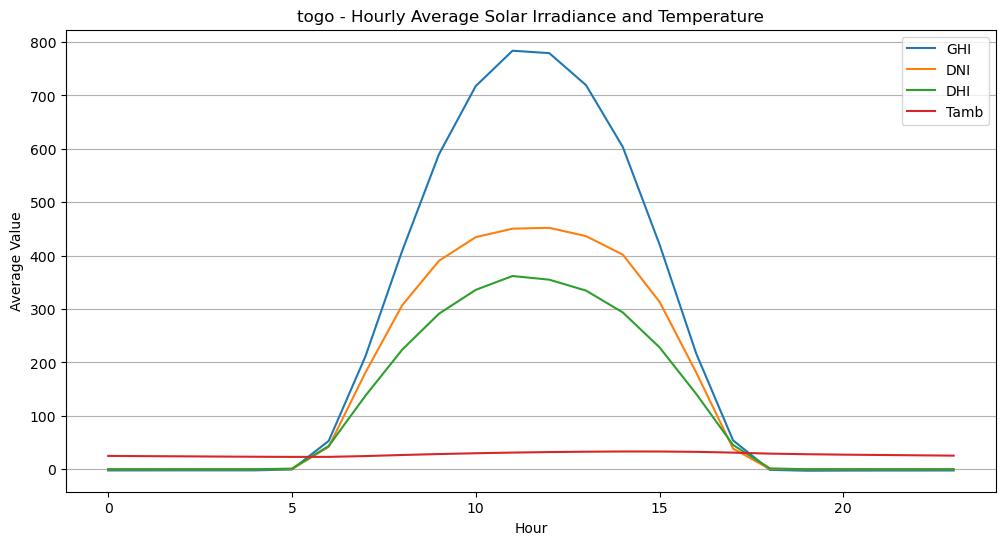

In [58]:
#implementing timeseries analysis
#Convert 'Timestamp' to datetime:

#Convert 'Timestamp' to datetime:

for country, df in dataframes.items(): 
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])




#Line charts of GHI, DNI, DHI, Tamb vs. Timestamp:

for country, df in dataframes.items(): 
    plt.figure(figsize=(12, 6))
    plt.plot(df['Timestamp'], df['GHI'], label='GHI')
    plt.plot(df['Timestamp'], df['DNI'], label='DNI')
    plt.plot(df['Timestamp'], df['DHI'], label='DHI')
    plt.plot(df['Timestamp'], df['Tamb'], label='Tamb')
    plt.xlabel('Timestamp')
    plt.ylabel('Irradiance / Temperature')
    plt.title(f'{country} - Time Series of Solar Irradiance and Temperature') 
    plt.legend()
    plt.grid(True)
    plt.show()




#Patterns by month:

for country, df in dataframes.items():
    df['Month'] = df['Timestamp'].dt.month
    monthly_avg = df.groupby('Month')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()
    monthly_avg.plot(kind='bar', figsize=(12, 6))
    plt.title(f'{country} - Monthly Average Solar Irradiance and Temperature') 
    plt.ylabel('Average Value')
    plt.xlabel('Month')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()




#Trends throughout day

for country, df in dataframes.items(): 
    df['Hour'] = df['Timestamp'].dt.hour
    hourly_avg = df.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()
    hourly_avg.plot(kind='line', figsize=(12, 6))
    plt.title(f'{country} - Hourly Average Solar Irradiance and Temperature') 
    plt.ylabel('Average Value')
    plt.xlabel('Hour')
    plt.xticks(rotation=0)
    plt.grid(axis='y')
    plt.show()





In [60]:
#showing Cleaning Impact by comparing the average 'ModA' and 'ModB' values before and after cleaning

for country, df in dataframes.items(): 
    mean_values = df.groupby('Outlier')[['ModA', 'ModB']].mean()
    print(f"\n---{country}---")
    print("Average ModA and ModB before and after cleaning:")
    print(mean_values)


---benin---
Average ModA and ModB before and after cleaning:
               ModA        ModB
Outlier                        
0        232.393310  225.026584
1        517.343618  486.943256

---sierraleone---
Average ModA and ModB before and after cleaning:
               ModA        ModB
Outlier                        
0        189.764194  181.693908
1        734.298355  711.448607

---togo---
Average ModA and ModB before and after cleaning:
               ModA        ModB
Outlier                        
0        219.380751  213.028150
1        603.659248  584.626257


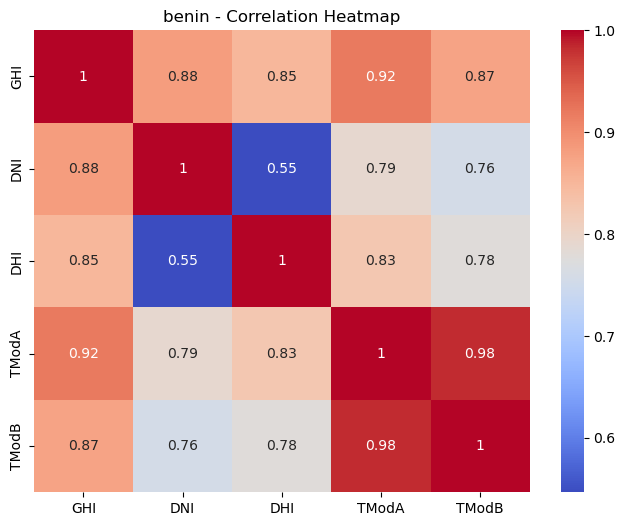

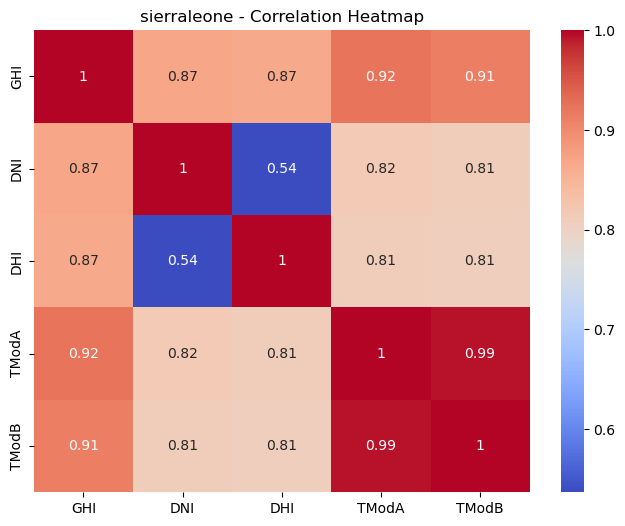

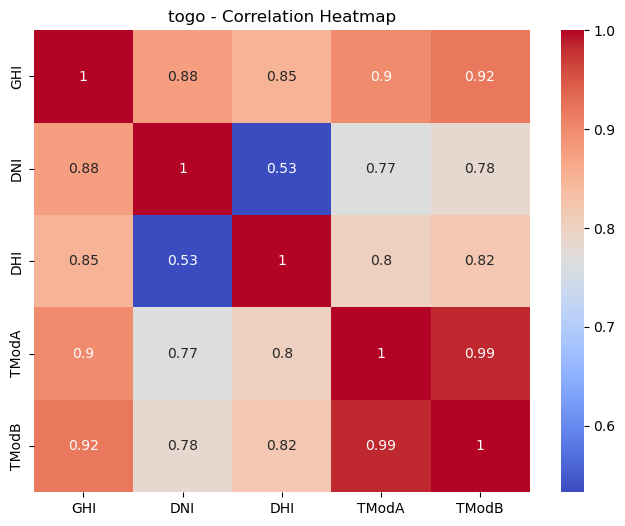

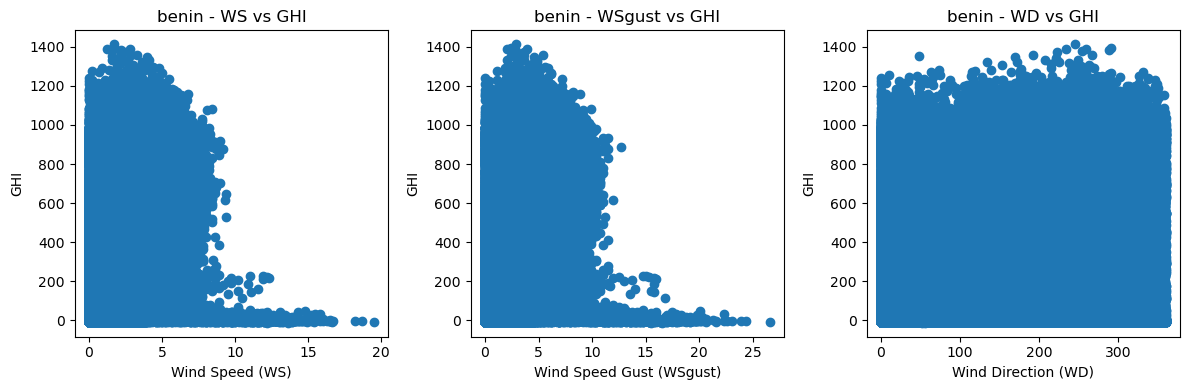

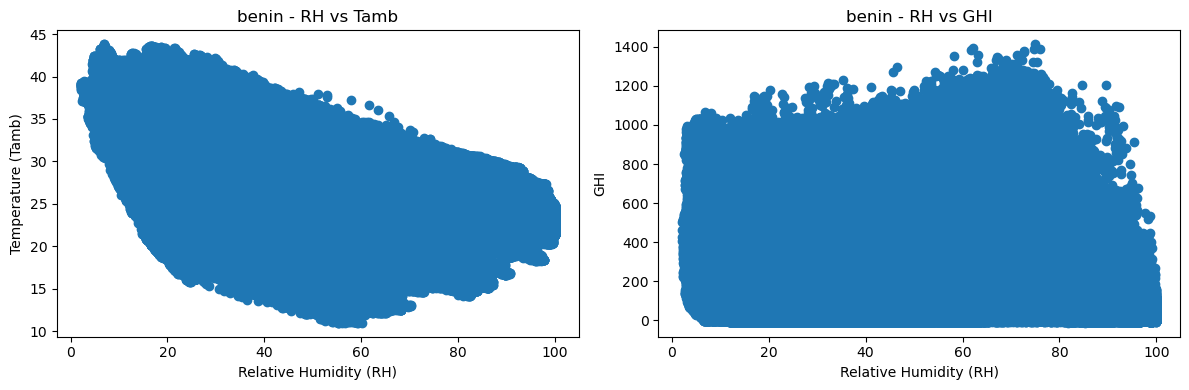

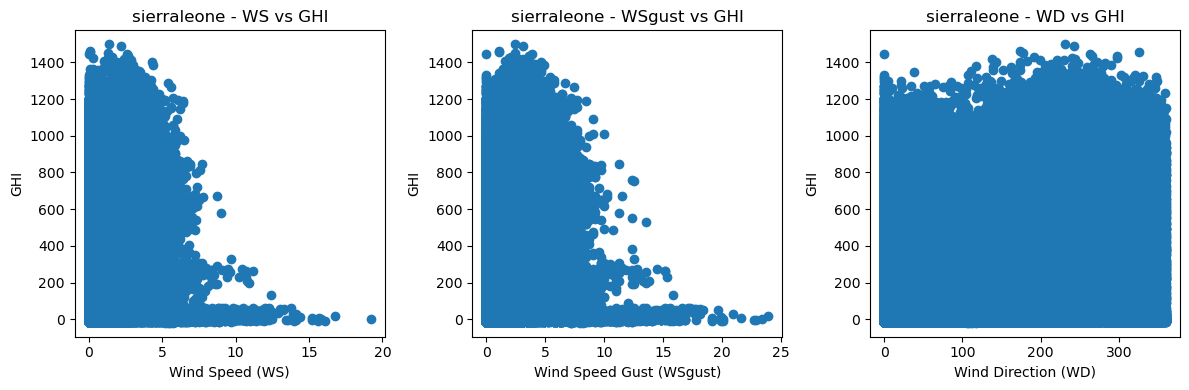

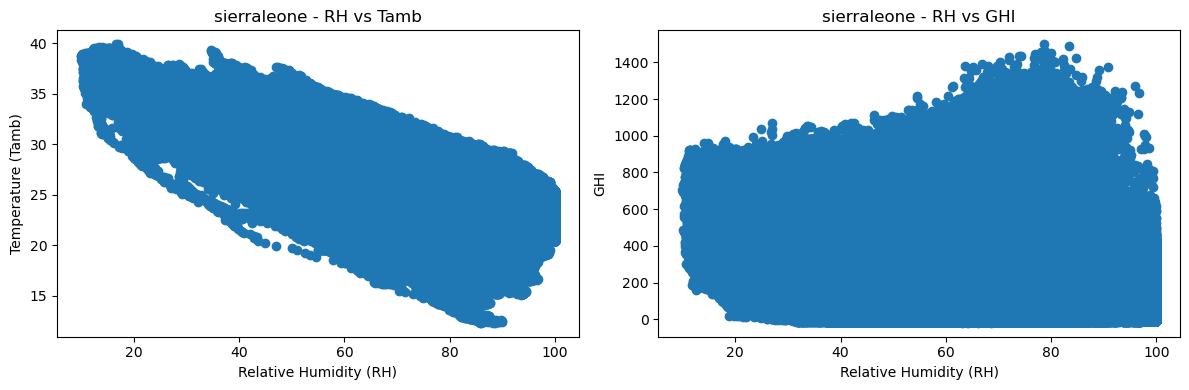

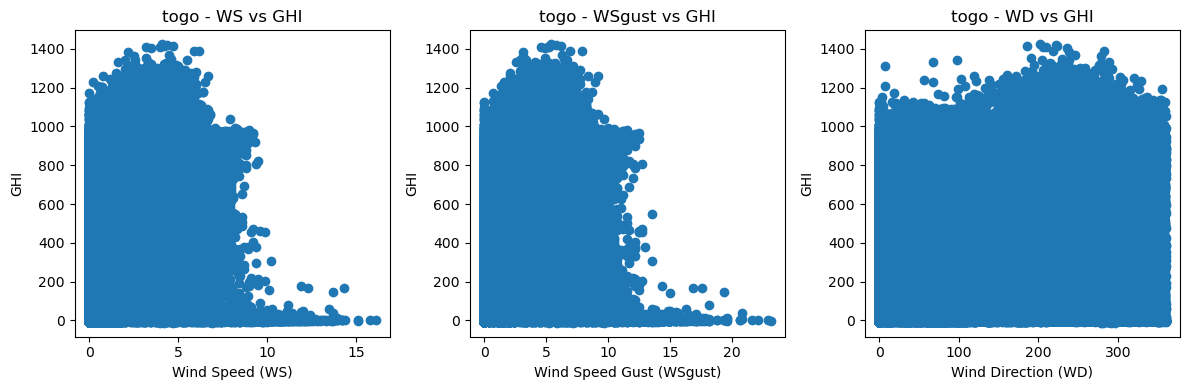

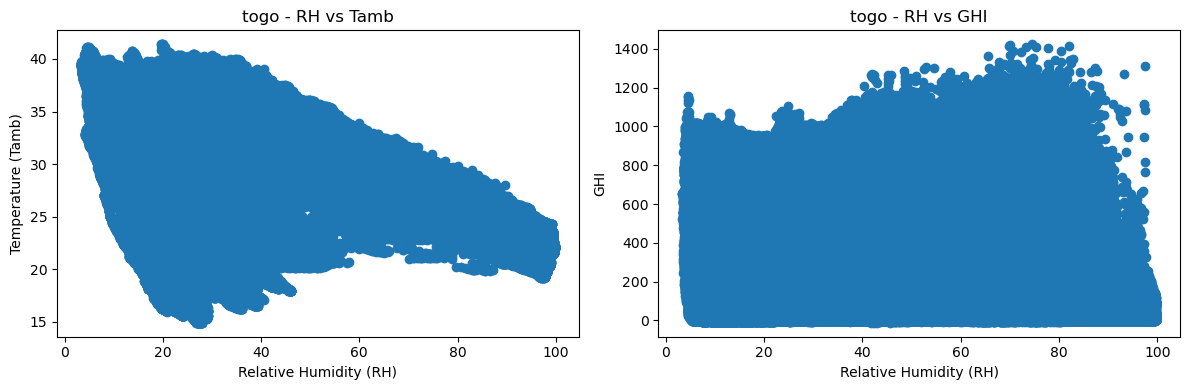

In [61]:
#Correlation & Relationship Analysis:

#Heatmap of correlations:

for country, df in dataframes.items(): 
    correlation_matrix = df[['GHI', 'DNI', 'DHI', 'TModA', 'TModB']].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'{country} - Correlation Heatmap') 
    plt.show()

#Scatter plots:

for country, df in dataframes.items(): 
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.scatter(df['WS'], df['GHI'])
    plt.xlabel('Wind Speed (WS)')
    plt.ylabel('GHI')
    plt.title(f'{country} - WS vs GHI')  

    plt.subplot(1, 3, 2)
    plt.scatter(df['WSgust'], df['GHI'])
    plt.xlabel('Wind Speed Gust (WSgust)')
    plt.ylabel('GHI')
    plt.title(f'{country} - WSgust vs GHI')  

    plt.subplot(1, 3, 3)
    plt.scatter(df['WD'], df['GHI'])
    plt.xlabel('Wind Direction (WD)')
    plt.ylabel('GHI')
    plt.title(f'{country} - WD vs GHI')  

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.scatter(df['RH'], df['Tamb'])
    plt.xlabel('Relative Humidity (RH)')
    plt.ylabel('Temperature (Tamb)')
    plt.title(f'{country} - RH vs Tamb') 

    plt.subplot(1,2,2)
    plt.scatter(df['RH'], df['GHI'])
    plt.xlabel('Relative Humidity (RH)')
    plt.ylabel('GHI')
    plt.title(f'{country} - RH vs GHI')  
    plt.tight_layout()
    plt.show()

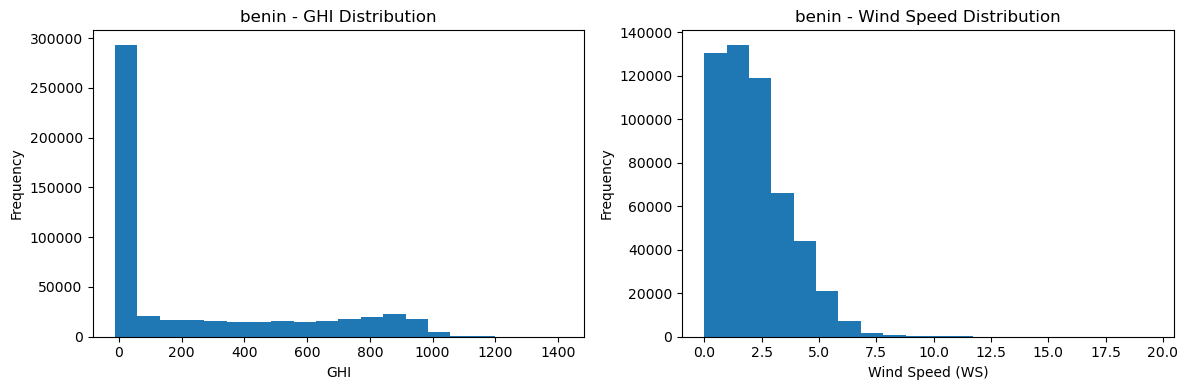

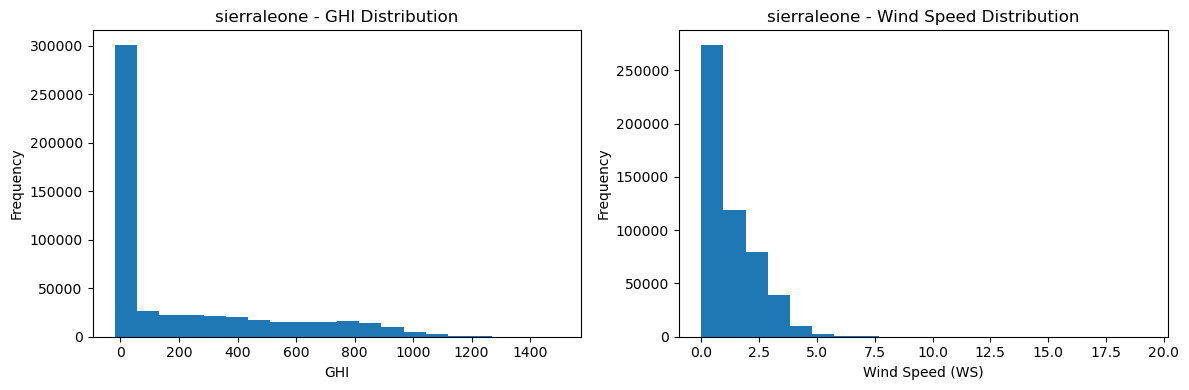

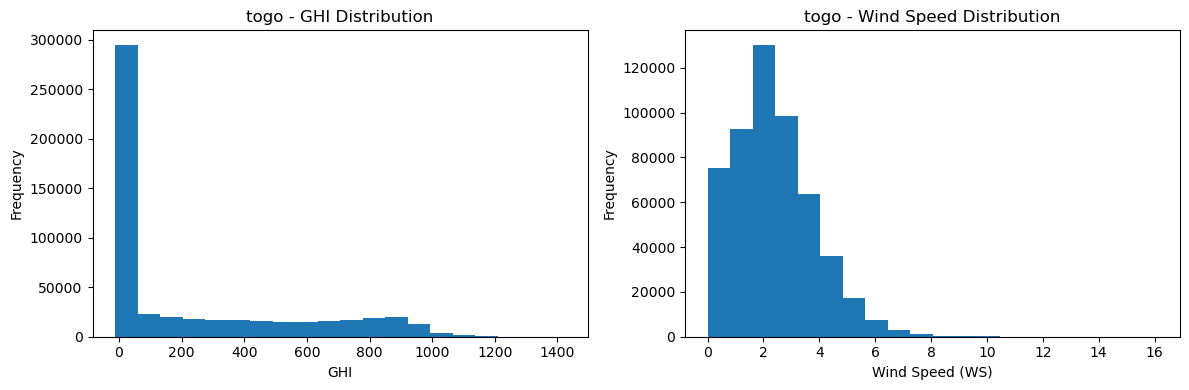

In [89]:
#Wind & Distribution Analysis:

#Wind rose plot
   
for country, df in dataframes.items():
    from matplotlib import pyplot

'''   try:
        from windrose import plot_rose
        fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(8,8))
        plot_rose(df['WD'], df['WS'], kind='bar', ax=ax)
        ax.set_title(f'{country} - Wind Rose Plot') 
        plt.show()
    except ImportError:
        print(f"Windrose is not installed. Skipping Wind Rose Plot for {country}.")
        print("Please install the windrose library.  You can install it using pip: pip install windrose")
'''


#Histograms:

for country, df in dataframes.items(): 
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.hist(df['GHI'], bins=20)
    plt.xlabel('GHI')
    plt.ylabel('Frequency')
    plt.title(f'{country} - GHI Distribution') 

    plt.subplot(1, 2, 2)
    plt.hist(df['WS'], bins=20) 
    plt.xlabel('Wind Speed (WS)')
    plt.ylabel('Frequency')
    plt.title(f'{country} - Wind Speed Distribution') 

    plt.tight_layout()
    plt.show()


In [70]:
#temperature analysis

for country, df in dataframes.items(): # added loop
    print(f"\n---{country}---") # Added country name
    print(df[['RH', 'Tamb', 'GHI']].corr())



---benin---
            RH      Tamb       GHI
RH    1.000000 -0.414842 -0.360029
Tamb -0.414842  1.000000  0.547513
GHI  -0.360029  0.547513  1.000000

---sierraleone---
            RH      Tamb       GHI
RH    1.000000 -0.791937 -0.546677
Tamb -0.791937  1.000000  0.641261
GHI  -0.546677  0.641261  1.000000

---togo---
            RH      Tamb       GHI
RH    1.000000 -0.400410 -0.258077
Tamb -0.400410  1.000000  0.562533
GHI  -0.258077  0.562533  1.000000


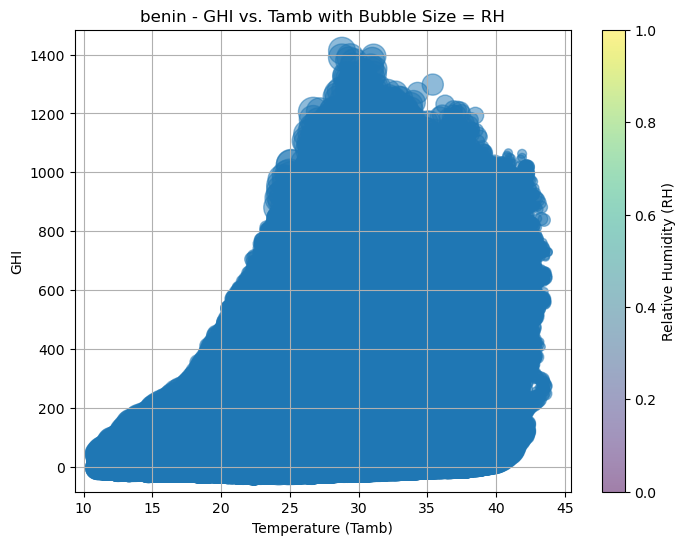

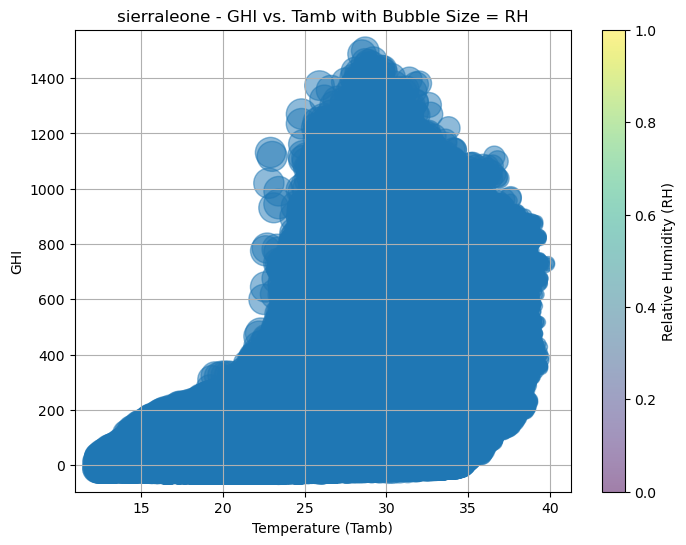

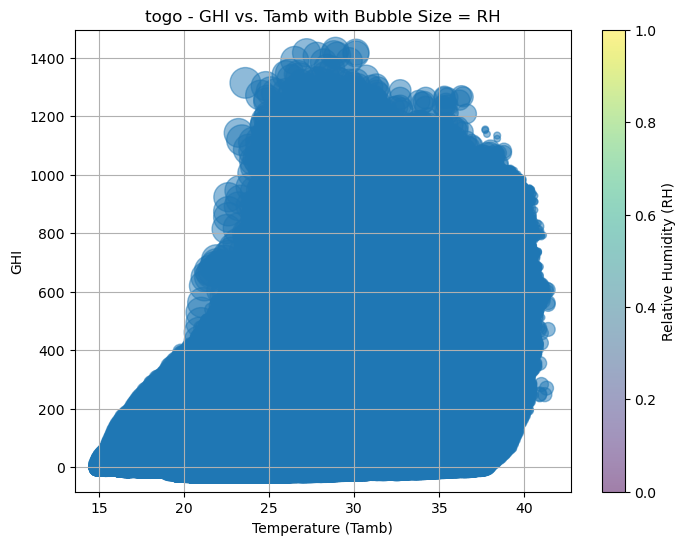

In [72]:
#Bubble Chart:GHI vs. Tamb with bubble size = RH:

for country, df in dataframes.items(): 
    plt.figure(figsize=(8, 6))
    plt.scatter(df['Tamb'], df['GHI'], s=df['RH'] * 5, alpha=0.5)
    plt.xlabel('Temperature (Tamb)')
    plt.ylabel('GHI')
    plt.title(f'{country} - GHI vs. Tamb with Bubble Size = RH')
    plt.colorbar(label='Relative Humidity (RH)')
    plt.grid(True)
    plt.show()